# Pitmon Demo

### Imports & Config

In [29]:
import numpy as np
import time as timer
from scipy import stats
from pitmon import PITMonitor
import matplotlib.pyplot as plt
from typing import Callable, Optional
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from dataclasses import dataclass

In [30]:
SEED = 0
np.random.seed(SEED)

In [31]:
VERBOSE_DEMO = True


def log(message: str = "") -> None:
    if VERBOSE_DEMO:
        print(message)

### Helpers

In [32]:
# Data Generation


def generate_features(n: int) -> np.ndarray:
    """Generate synthetic delivery features: distance, weight, complexity, time_of_day."""
    distance = np.random.lognormal(mean=4.5, sigma=0.6, size=n)
    weight = np.random.exponential(scale=5, size=n) + 0.5
    complexity = np.random.beta(2, 5, size=n)
    time_of_day = np.random.uniform(0, 2 * np.pi, size=n)
    return np.column_stack([distance, weight, complexity, time_of_day])


def true_delivery_time_regime(X: np.ndarray, regime: str = "before") -> np.ndarray:
    """Ground truth delivery time with regime switching (before/after highway)."""
    distance, weight, complexity, tod = X[:, 0], X[:, 1], X[:, 2], X[:, 3]
    base = 8 + 0.15 * distance + 0.08 * distance * complexity + 0.3 * weight
    rush_hour = 3.0 * np.exp(-((tod - 2.5) ** 2) / 0.5)
    noise_std = 1.5 + 0.02 * distance
    noise = np.random.normal(0, noise_std, size=len(distance))

    if regime == "after":
        highway_benefit = 0.30 * base * (1 / (1 + np.exp(-0.03 * (distance - 50))))
        return base + rush_hour - highway_benefit + noise * 0.7
    return base + rush_hour + noise


def true_delivery_time_shift(X: np.ndarray, shift_fraction: float = 0.0) -> np.ndarray:
    """Ground truth delivery time with fractional shift magnitude."""
    distance, weight, complexity, tod = X[:, 0], X[:, 1], X[:, 2], X[:, 3]
    base = 8 + 0.15 * distance + 0.08 * distance * complexity + 0.3 * weight
    rush_hour = 3.0 * np.exp(-((tod - 2.5) ** 2) / 0.5)
    noise_std = 1.5 + 0.02 * distance
    noise = np.random.normal(0, noise_std, size=len(distance))

    if shift_fraction > 0:
        benefit = shift_fraction * base * (1 / (1 + np.exp(-0.03 * (distance - 50))))
        return base + rush_hour - benefit + noise * (1 - 0.3 * shift_fraction)
    return base + rush_hour + noise

In [33]:
# Monitoring


@dataclass
class MonitoringRun:
    monitor: PITMonitor
    evidence_trace: np.ndarray
    pit_trace: np.ndarray
    pred_trace: np.ndarray


def make_mlp_classifier(random_state: int = SEED) -> MLPClassifier:
    """Create the default MLP used across the demo."""
    return MLPClassifier(
        hidden_layer_sizes=(64, 32, 16),
        activation="relu",
        solver="adam",
        max_iter=500,
        early_stopping=True,
        validation_fraction=0.1,
        random_state=random_state,
        learning_rate_init=0.001,
    )


def build_bin_edges(y: np.ndarray, n_bins: int) -> np.ndarray:
    """Build padded quantile bin edges for a continuous target."""
    inner = np.quantile(y, np.linspace(0, 1, n_bins + 1))
    inner = np.unique(inner)
    if len(inner) < 3:
        raise RuntimeError("Not enough unique target values to build bins.")
    pad = max(np.std(y), 1.0)
    return np.concatenate(([inner[0] - pad], inner[1:-1], [inner[-1] + pad]))


def expand_probs_to_full_bins(
    probs_seen: np.ndarray,
    classes_seen: np.ndarray,
    n_bins: int,
) -> np.ndarray:
    """Expand sparse class probabilities to a full bin vector and renormalize."""
    probs_full = np.zeros(n_bins, dtype=float)
    probs_full[classes_seen.astype(int)] = probs_seen
    total = probs_full.sum()
    if total <= 0:
        probs_full[:] = 1.0 / n_bins
    else:
        probs_full /= total
    return probs_full


def cdf_from_edges(probs: np.ndarray, y: float, edges: np.ndarray) -> float:
    """Compute piecewise-linear CDF from bin masses and bin edges."""
    if y <= edges[0]:
        return 0.0
    if y >= edges[-1]:
        return 1.0

    k_local = len(edges) - 1
    k = int(np.searchsorted(edges, y, side="right") - 1)
    k = int(np.clip(k, 0, k_local - 1))

    cdf_left = probs[:k].sum() if k > 0 else 0.0
    width = edges[k + 1] - edges[k]
    frac = 0.0 if width <= 0 else (y - edges[k]) / width
    frac = float(np.clip(frac, 0.0, 1.0))

    return float(np.clip(cdf_left + probs[k] * frac, 0.0, 1.0))


def summarize_power_trials(trials: list[dict], n_trials: int) -> dict:
    """Aggregate trial-level monitoring results into power statistics."""
    n_alarms = sum(t["alarm_fired"] for t in trials)
    n_false = sum(t["false_alarm"] for t in trials)
    n_detect = sum(1 for t in trials if t["alarm_fired"] and not t["false_alarm"])
    alarm_rate = n_alarms / n_trials
    false_rate = n_false / n_trials
    tpr = n_detect / n_trials

    delays = [t["detection_delay"] for t in trials if t["detection_delay"] is not None]
    median_delay = np.median(delays) if delays else float("nan")
    mean_delay = np.mean(delays) if delays else float("nan")

    def wilson_ci(k: int, n: int, z: float = 1.96) -> tuple[float, float]:
        if n <= 0:
            return float("nan"), float("nan")
        p_hat = k / n
        denom = 1 + z**2 / n
        center = (p_hat + z**2 / (2 * n)) / denom
        radius = z * np.sqrt((p_hat * (1 - p_hat) + z**2 / (4 * n)) / n) / denom
        return float(max(0.0, center - radius)), float(min(1.0, center + radius))

    tpr_ci_low, tpr_ci_high = wilson_ci(n_detect, n_trials)
    fpr_ci_low, fpr_ci_high = wilson_ci(n_false, n_trials)

    return {
        "n_trials": n_trials,
        "n_alarms": n_alarms,
        "n_false": n_false,
        "n_detect": n_detect,
        "alarm_rate": alarm_rate,
        "false_alarm_rate": false_rate,
        "tpr": tpr,
        "tpr_ci_low": tpr_ci_low,
        "tpr_ci_high": tpr_ci_high,
        "fpr_ci_low": fpr_ci_low,
        "fpr_ci_high": fpr_ci_high,
        "median_delay": median_delay,
        "mean_delay": mean_delay,
        "delays": delays,
        "evidences": [t["final_evidence"] for t in trials],
    }


def compute_pits(
    X: np.ndarray,
    y: np.ndarray,
    predictive_cdf: Callable[[np.ndarray, float], float],
) -> np.ndarray:
    """Compute PIT values for a feature/target batch."""
    pits = np.empty(len(y), dtype=float)
    for i in range(len(y)):
        pits[i] = float(np.clip(predictive_cdf(X[i], float(y[i])), 0.0, 1.0))
    return pits


def compute_pits_batch(
    X: np.ndarray,
    y: np.ndarray,
    cdf_func: Callable[[np.ndarray, np.ndarray], np.ndarray],
) -> np.ndarray:
    """
    Batch compute PIT values using a vectorized CDF function.

    Parameters
    ----------
    X : np.ndarray
        Feature matrix (n_samples, n_features)
    y : np.ndarray
        Target values (n_samples,)
    cdf_func : Callable
        Function that takes (X, y) and returns CDF values for each pair

    Returns
    -------
    np.ndarray
        PIT values clipped to [0, 1]
    """
    return np.clip(cdf_func(X, y), 0.0, 1.0)


def report_ks_calibration(pits: np.ndarray, alpha: float = 0.05) -> tuple[float, float]:
    """Print and return KS calibration diagnostics against Uniform(0,1)."""
    ks_stat, ks_pval = stats.kstest(np.asarray(pits), "uniform")
    print(f"  KS statistic     : {ks_stat:.4f}")
    print(f"  KS p-value       : {ks_pval:.4f}")
    print(
        f"  Calibration      : {'PASS' if ks_pval > alpha else 'FAIL'} (p > {alpha:.2f})"
    )
    return float(ks_stat), float(ks_pval)


def report_calibration_from_monitor(monitor: PITMonitor, alpha: float = 0.05) -> float:
    """Report calibration diagnostics from a PITMonitor instance."""
    ks_stat = monitor.calibration_score()
    pits = monitor.pits
    _, ks_pval = stats.kstest(pits, "uniform")
    print(f"  KS statistic     : {ks_stat:.4f}")
    print(f"  KS p-value       : {ks_pval:.4f}")
    print(
        f"  Calibration      : {'PASS' if ks_pval > alpha else 'FAIL'} (p > {alpha:.2f})"
    )
    return ks_stat


def run_monitoring_session(
    X: np.ndarray,
    y: np.ndarray,
    predictive_cdf: Callable[[np.ndarray, float], float],
    predict_mean: Optional[Callable[[np.ndarray], float]] = None,
    *,
    alpha: float = 0.05,
    n_bins: int = 10,
    stable_cutoff: Optional[int] = None,
) -> MonitoringRun:
    """Run PITMonitor over a stream and collect traces for plotting/reporting."""
    monitor = PITMonitor(alpha=alpha, n_bins=n_bins)

    pred_trace = []

    for i in range(len(y)):
        x_i = X[i]
        y_i = float(y[i])

        if predict_mean is not None:
            pred_trace.append(float(predict_mean(x_i)))

        pit = float(np.clip(predictive_cdf(x_i, y_i), 0.0, 1.0))
        alarm = monitor.update(pit)

        t = i + 1
        if stable_cutoff is not None and t == stable_cutoff:
            log(f"Stable period ended at t={t}; evidence={alarm.evidence:.4f}")
        if alarm.triggered and t == alarm.time:
            log(
                f"Alarm at t={t}; evidence={alarm.evidence:.1f} (threshold={alarm.threshold:.0f})"
            )

    evidence_trace = np.array([alarm.evidence for alarm in monitor.history()])
    pit_trace = monitor.pits

    return MonitoringRun(
        monitor=monitor,
        evidence_trace=evidence_trace,
        pit_trace=pit_trace,
        pred_trace=np.asarray(pred_trace, dtype=float),
    )

In [34]:
# Power Analysis


def batch_predictive_cdf(X_batch: np.ndarray, y_batch: np.ndarray) -> np.ndarray:
    """
    Vectorized CDF evaluation for power analysis efficiency.

    Parameters
    ----------
    X_batch : np.ndarray, shape (n, n_features)
    y_batch : np.ndarray, shape (n,)

    Returns
    -------
    np.ndarray, shape (n,)
        CDF values F(y_i | x_i) for each sample i
    """
    X_s = scaler.transform(X_batch)
    probs_seen_batch = nn.predict_proba(X_s)
    n = len(y_batch)
    cdfs = np.empty(n, dtype=float)

    for i in range(n):
        probs = full_bin_probs(probs_seen_batch[i])
        cdfs[i] = cdf_from_bin_probs(probs, y_batch[i])

    return cdfs


def run_power_trial(
    shift_fraction: float,
    n_stable: int,
    n_shifted: int,
    alpha: float = 0.05,
    n_bins: int = 10,
    trial_seed: Optional[int] = None,
) -> dict:
    """
    Run one monitoring trial with a specified shift magnitude.

        The shift_fraction parameter controls how much the delivery times are
        reduced in the shifted period:
            - shift_fraction = 0.0  →  no shift (H₀)
            - shift_fraction = 1.0  →  full shift (matches the "after" regime)
            - 0 < shift_fraction < 1  →  partial shift

    Returns
    -------
    dict
        Standard trial summary from PITMonitor
    """
    if trial_seed is not None:
        np.random.seed(trial_seed)

    # Generate stable period data
    X_stable = generate_features(n_stable)
    y_stable = true_delivery_time_regime(X_stable, regime="before")

    # Generate shifted period data
    X_shifted = generate_features(n_shifted)
    y_shifted = true_delivery_time_shift(X_shifted, shift_fraction=shift_fraction)

    # Combine data
    X_all = np.vstack([X_stable, X_shifted])
    y_all = np.concatenate([y_stable, y_shifted])

    # Batch compute PITs
    pits = compute_pits_batch(X_all, y_all, batch_predictive_cdf)

    # Run monitoring trial using PITMonitor's built-in methods
    monitor = PITMonitor(alpha=alpha, n_bins=n_bins)
    monitor.update_many(pits, stop_on_alarm=True)
    return monitor.trial_summary(n_stable)

## Part 1: Detecting a Single Regime Shift

A logistics company trains a neural network (sklearn MLPClassifier with softmax
output) to predict package delivery times from features like distance, package
weight, and route complexity. The network is trained on 2,000 historical
shipments where conditions were stable.

After deployment, PITMonitor watches the NN's probabilistic forecasts against
reality. For the first 300 shipments, everything is fine — the model is well
calibrated. Then a new highway opens, systematically cutting delivery times in
the region. The NN knows nothing about this infrastructure change.

PITMonitor detects the resulting miscalibration and fires an alarm, signaling
it's time to retrain.

### 1)a) Train NN

In [35]:
log("Step 1: Train softmax NN on historical data")

N_TRAIN = 2000
N_CAL = 500
N_Y_BINS = 50  # Number of softmax output bins
MONITOR_ALPHA = 0.05  # False positive rate bound
MONITOR_N_BINS = 10  # Monitoring histogram bins

X_train = generate_features(N_TRAIN)
y_train = true_delivery_time_regime(X_train, regime="before")

X_cal = generate_features(N_CAL)
y_cal = true_delivery_time_regime(X_cal, regime="before")

scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_cal_s = scaler.transform(X_cal)

# Build bin edges on train labels, padded on both sides to avoid clipping
bin_edges = build_bin_edges(y_train, N_Y_BINS)
K = len(bin_edges) - 1


def y_to_bin_index(y: np.ndarray) -> np.ndarray:
    return np.digitize(y, bin_edges[1:-1], right=False)


y_train_bins = y_to_bin_index(y_train)
y_cal_bins = y_to_bin_index(y_cal)

nn = make_mlp_classifier(random_state=SEED)
nn.fit(X_train_s, y_train_bins)

train_acc = nn.score(X_train_s, y_train_bins)
cal_acc = nn.score(X_cal_s, y_cal_bins)

log(f"Architecture: {nn.hidden_layer_sizes}")
log(f"Target bins (K): {K}")
log(f"Train bin accuracy: {train_acc:.4f}")
log(f"Cal bin accuracy: {cal_acc:.4f}")
log(f"Target range: [{bin_edges[0]:.2f}, {bin_edges[-1]:.2f}] hours")


def full_bin_probs(probs_seen: np.ndarray) -> np.ndarray:
    """
    Expand predict_proba output to all K bins and renormalize.
    Some bins can be absent from nn.classes_ if unobserved in training labels.
    """
    return expand_probs_to_full_bins(probs_seen, nn.classes_, K)

### 1)b) Build CDF

In [36]:
log("Step 2: Construct CDF from softmax bin probabilities")


def cdf_from_bin_probs(probs: np.ndarray, y: float) -> float:
    return cdf_from_edges(probs, y, bin_edges)


def predictive_cdf(x: np.ndarray, y: float) -> float:
    x_s = scaler.transform(x.reshape(1, -1))
    probs = full_bin_probs(nn.predict_proba(x_s)[0])
    return cdf_from_bin_probs(probs, y)


def validate_softmax_cdf(
    n_checks: int = 32, grid_size: int = 200, verbose: bool = True
) -> bool:
    """
    Validate that the constructed CDF is mathematically well-formed.

    Returns
    -------
    bool
        True if all checks pass, raises ValueError otherwise.
    """
    X_chk = generate_features(n_checks)
    probs_seen_batch = nn.predict_proba(scaler.transform(X_chk))
    y_grid = np.linspace(bin_edges[0], bin_edges[-1], grid_size)
    max_mass_err = 0.0

    for row in probs_seen_batch:
        probs = full_bin_probs(row)

        if np.any(probs < -1e-12):
            raise ValueError("Invalid bin probabilities: negative mass.")

        mass_err = abs(probs.sum() - 1.0)
        max_mass_err = max(max_mass_err, mass_err)
        if mass_err > 1e-8:
            raise ValueError("Invalid bin probabilities: total mass is not 1.")

        cdf_vals = np.array([cdf_from_bin_probs(probs, yv) for yv in y_grid])
        if np.any(np.diff(cdf_vals) < -1e-10):
            raise ValueError("Invalid CDF: not monotone non-decreasing.")
        if cdf_vals.min() < -1e-10 or cdf_vals.max() > 1 + 1e-10:
            raise ValueError("Invalid CDF: values outside [0, 1].")

        left = cdf_from_bin_probs(probs, bin_edges[0] - 1e6)
        right = cdf_from_bin_probs(probs, bin_edges[-1] + 1e6)
        if abs(left) > 1e-10 or abs(right - 1.0) > 1e-10:
            raise ValueError("Invalid CDF tail limits.")

        integrated_mass = np.diff(cdf_vals).sum()
        if abs(integrated_mass - 1.0) > 1e-3:
            raise ValueError("Invalid CDF: numerical integrated mass not close to 1.")

    if verbose:
        log(f"CDF checks: PASS ({n_checks} samples)")
        log(f"Max mass error: {max_mass_err:.2e}")
    return True


validate_softmax_cdf()

True

### 1)c) Deploy and Visualize

In [37]:
log("Step 3: Deploy PITMonitor (300 stable → 200 shifted)")

N_STABLE = 300
N_SHIFTED = 200
N_TOTAL = N_STABLE + N_SHIFTED
TRUE_CHANGE = N_STABLE + 1

X_stable = generate_features(N_STABLE)
y_stable = true_delivery_time_regime(X_stable, regime="before")

X_shifted = generate_features(N_SHIFTED)
y_shifted = true_delivery_time_regime(X_shifted, regime="after")

X_all = np.vstack([X_stable, X_shifted])
y_all = np.concatenate([y_stable, y_shifted])

bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])


def predict_mean(x: np.ndarray) -> float:
    x_s = scaler.transform(x.reshape(1, -1))
    probs_i = full_bin_probs(nn.predict_proba(x_s)[0])
    return float(np.dot(probs_i, bin_centers))


run = run_monitoring_session(
    X_all,
    y_all,
    predictive_cdf,
    predict_mean=predict_mean,
    alpha=MONITOR_ALPHA,
    n_bins=MONITOR_N_BINS,
    stable_cutoff=N_STABLE,
)
monitor = run.monitor
evidence_trace = run.evidence_trace
pit_trace = run.pit_trace
pred_trace = run.pred_trace

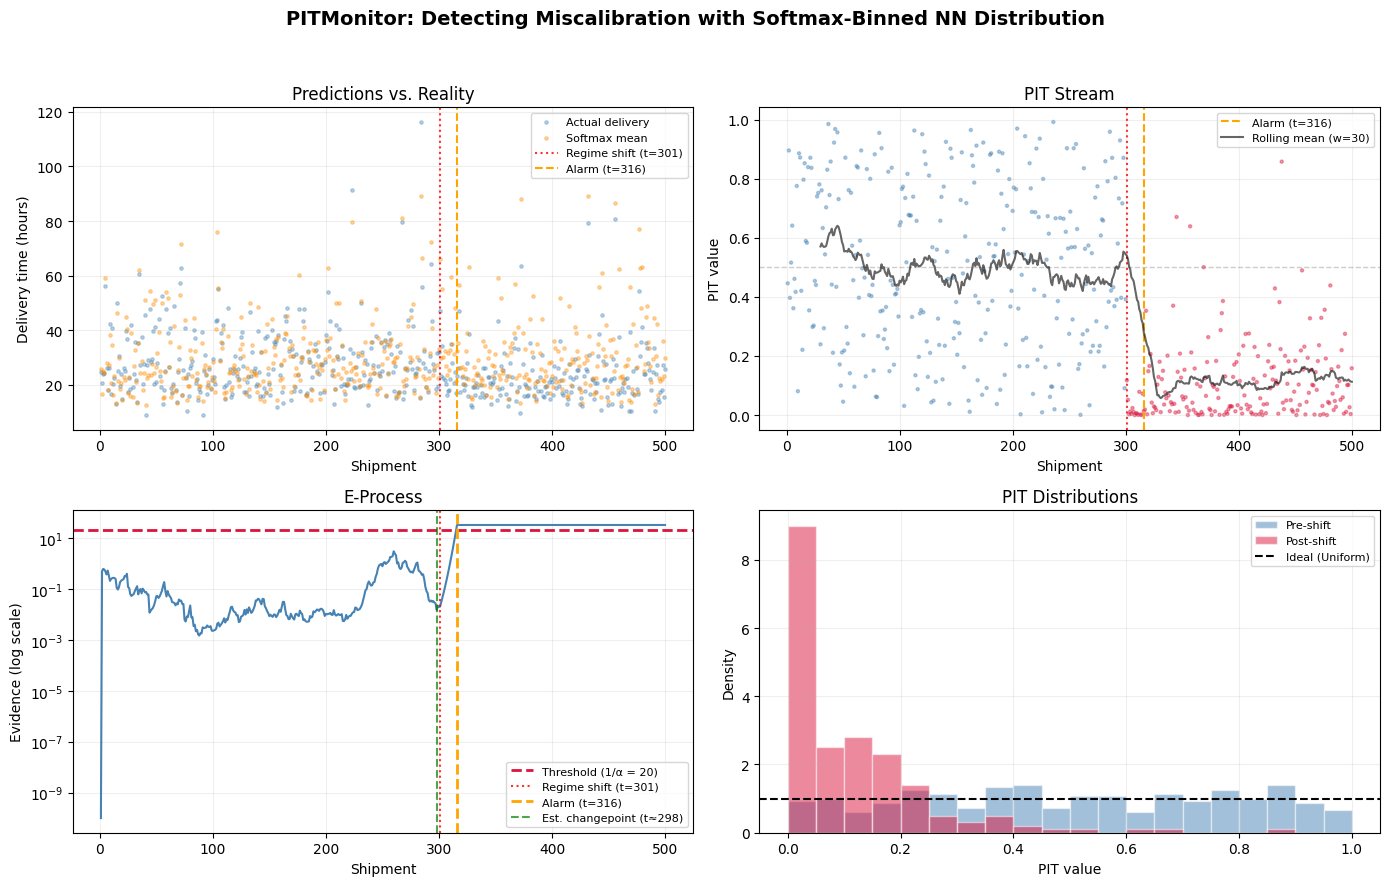

In [38]:
summary = monitor.summary()
est_cp = summary["changepoint"]

print("Results")
print(f"Model: MLPClassifier{nn.hidden_layer_sizes} (softmax bins)")
print(f"Observations: {summary['t']}")
print(f"Alarm triggered: {'Yes' if summary['alarm_triggered'] else 'No'}")
if summary["alarm_triggered"]:
    print(f"Alarm time: t = {summary['alarm_time']}")
    print(f"True changepoint: t = {TRUE_CHANGE}")
    print(f"Estimated changepoint: t ≈ {est_cp}")
    print(f"Detection delay: {summary['alarm_time'] - TRUE_CHANGE} observations")
print(f"Final evidence: {summary['evidence']:.1f}")
print(f"KS calibration score: {summary['calibration_score']:.4f}")

times = np.arange(1, N_TOTAL + 1)
evidence = np.array(evidence_trace)
pits = np.array(pit_trace)
preds = np.array(pred_trace)

fig, axes = plt.subplots(2, 2, figsize=(14, 9))
fig.suptitle(
    "PITMonitor: Detecting Miscalibration with Softmax-Binned NN Distribution",
    fontsize=14,
    fontweight="bold",
)

# Panel 1
ax = axes[0, 0]
ax.scatter(
    times, y_all, s=6, alpha=0.35, c="steelblue", label="Actual delivery", zorder=2
)
ax.scatter(
    times, preds, s=6, alpha=0.35, c="darkorange", label="Softmax mean", zorder=2
)
ax.axvline(
    TRUE_CHANGE,
    color="red",
    ls=":",
    lw=1.5,
    alpha=0.8,
    label=f"Regime shift (t={TRUE_CHANGE})",
)
if monitor.alarm_time:
    ax.axvline(
        monitor.alarm_time,
        color="orange",
        ls="--",
        lw=1.5,
        label=f"Alarm (t={monitor.alarm_time})",
    )
ax.set(
    xlabel="Shipment", ylabel="Delivery time (hours)", title="Predictions vs. Reality"
)
ax.legend(fontsize=8)
ax.grid(True, alpha=0.2)

# Panel 2
ax = axes[0, 1]
colors = np.where(times <= N_STABLE, "steelblue", "crimson")
ax.scatter(times, pits, s=5, alpha=0.4, c=colors)
ax.axhline(0.5, color="gray", ls="--", lw=1, alpha=0.4)
ax.axvline(TRUE_CHANGE, color="red", ls=":", lw=1.5, alpha=0.8)
if monitor.alarm_time:
    ax.axvline(
        monitor.alarm_time,
        color="orange",
        ls="--",
        lw=1.5,
        label=f"Alarm (t={monitor.alarm_time})",
    )
rolling_pit = np.convolve(pits, np.ones(30) / 30, mode="valid")
ax.plot(
    np.arange(30, N_TOTAL + 1),
    rolling_pit,
    color="black",
    lw=1.5,
    alpha=0.6,
    label="Rolling mean (w=30)",
)
ax.set(xlabel="Shipment", ylabel="PIT value", title="PIT Stream")
ax.legend(fontsize=8)
ax.grid(True, alpha=0.2)

# Panel 3
ax = axes[1, 0]
ax.semilogy(times, np.maximum(evidence, 1e-10), color="steelblue", lw=1.5)
ax.axhline(
    monitor.threshold,
    color="crimson",
    ls="--",
    lw=2,
    label=f"Threshold (1/α = {monitor.threshold:.0f})",
)
ax.axvline(
    TRUE_CHANGE,
    color="red",
    ls=":",
    lw=1.5,
    alpha=0.8,
    label=f"Regime shift (t={TRUE_CHANGE})",
)
if monitor.alarm_time:
    ax.axvline(
        monitor.alarm_time,
        color="orange",
        ls="--",
        lw=2,
        label=f"Alarm (t={monitor.alarm_time})",
    )
if est_cp:
    ax.axvline(
        est_cp,
        color="green",
        ls="--",
        lw=1.5,
        alpha=0.7,
        label=f"Est. changepoint (t≈{est_cp})",
    )
ax.set(xlabel="Shipment", ylabel="Evidence (log scale)", title="E-Process")
ax.legend(fontsize=8)
ax.grid(True, alpha=0.2)

# Panel 4
ax = axes[1, 1]
hist_bins = np.linspace(0, 1, 21)
ax.hist(
    pits[:N_STABLE],
    bins=hist_bins,
    density=True,
    alpha=0.5,
    color="steelblue",
    edgecolor="white",
    label="Pre-shift",
)
ax.hist(
    pits[N_STABLE:],
    bins=hist_bins,
    density=True,
    alpha=0.5,
    color="crimson",
    edgecolor="white",
    label="Post-shift",
)
ax.axhline(1.0, color="black", ls="--", lw=1.5, label="Ideal (Uniform)")
ax.set(xlabel="PIT value", ylabel="Density", title="PIT Distributions")
ax.legend(fontsize=8)
ax.grid(True, alpha=0.2)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

## Part 2: Power Analysis

We know the false positive rate (FPR) is bounded by Ville's inequality:
P(ever alarm | H₀) ≤ α. But how well does PITMonitor actually detect real
miscalibration?

This section estimates:
  1. FPR under no shift - verifies FPR ≤ α
  2. TPR for varying shift magnitudes
  3. Detection delay distribution when alarms fire
  4. How power scales with shift magnitude

### 2)a) Monte Carlo

In [39]:
log("Part 2: Power analysis")
log("Estimating detection rate as shift magnitude increases")

In [40]:
ALPHA_POWER = 0.05
N_STABLE_POWER = 200
N_SHIFTED_POWER = 200
N_TRIALS = 250

# Shift magnitudes to test
# Note: 0.0 = H₀, 1.0 = full "after" shift (~30% reduction for long distances)
SHIFT_LEVELS = [0.0, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 1.0]

log(
    f"Running power analysis: {N_TRIALS} trials × {len(SHIFT_LEVELS)} shifts, "
    f"α={ALPHA_POWER}, n_stable={N_STABLE_POWER}, n_shifted={N_SHIFTED_POWER}"
)

power_results = {}
t0_power = timer.time()

for shift_frac in SHIFT_LEVELS:
    trials = []
    for trial_idx in range(N_TRIALS):
        trial_result = run_power_trial(
            shift_frac,
            N_STABLE_POWER,
            N_SHIFTED_POWER,
            alpha=ALPHA_POWER,
            trial_seed=SEED + trial_idx,
        )
        trials.append(trial_result)

    power_results[shift_frac] = summarize_power_trials(trials, n_trials=N_TRIALS)

    label = "H₀" if shift_frac == 0 else f"{shift_frac:.0%}"
    elapsed = timer.time() - t0_power
    shift_stats = power_results[shift_frac]
    log(
        f"shift={label:>4s} | alarm={shift_stats['alarm_rate']:>5.1%} "
        f"FP={shift_stats['false_alarm_rate']:>5.1%} TPR={shift_stats['tpr']:>5.1%} "
        f"med_delay={shift_stats['median_delay']:>6.0f} [{elapsed:>5.0f}s]"
    )

In [41]:
print("Shift-wise summary (FPR / TPR)")
for shift_frac in SHIFT_LEVELS:
    r = power_results[shift_frac]
    label = "H₀" if shift_frac == 0 else f"{shift_frac:.0%}"
    print(f"{label:>6s}: FPR={r['false_alarm_rate']:>6.1%}, TPR={r['tpr']:>6.1%}")

print(
    f"Ville's bound check: FPR ≤ α={ALPHA_POWER:.0%} "
    f"{'✓' if power_results[0.0]['false_alarm_rate'] <= ALPHA_POWER else '✗'}"
)
print(
    f"Observation budget: {N_STABLE_POWER} + {N_SHIFTED_POWER} = "
    f"{N_STABLE_POWER + N_SHIFTED_POWER} per trial"
)
print(f"Total computation time: {timer.time() - t0_power:.1f}s")

### 2)b) Visualizations

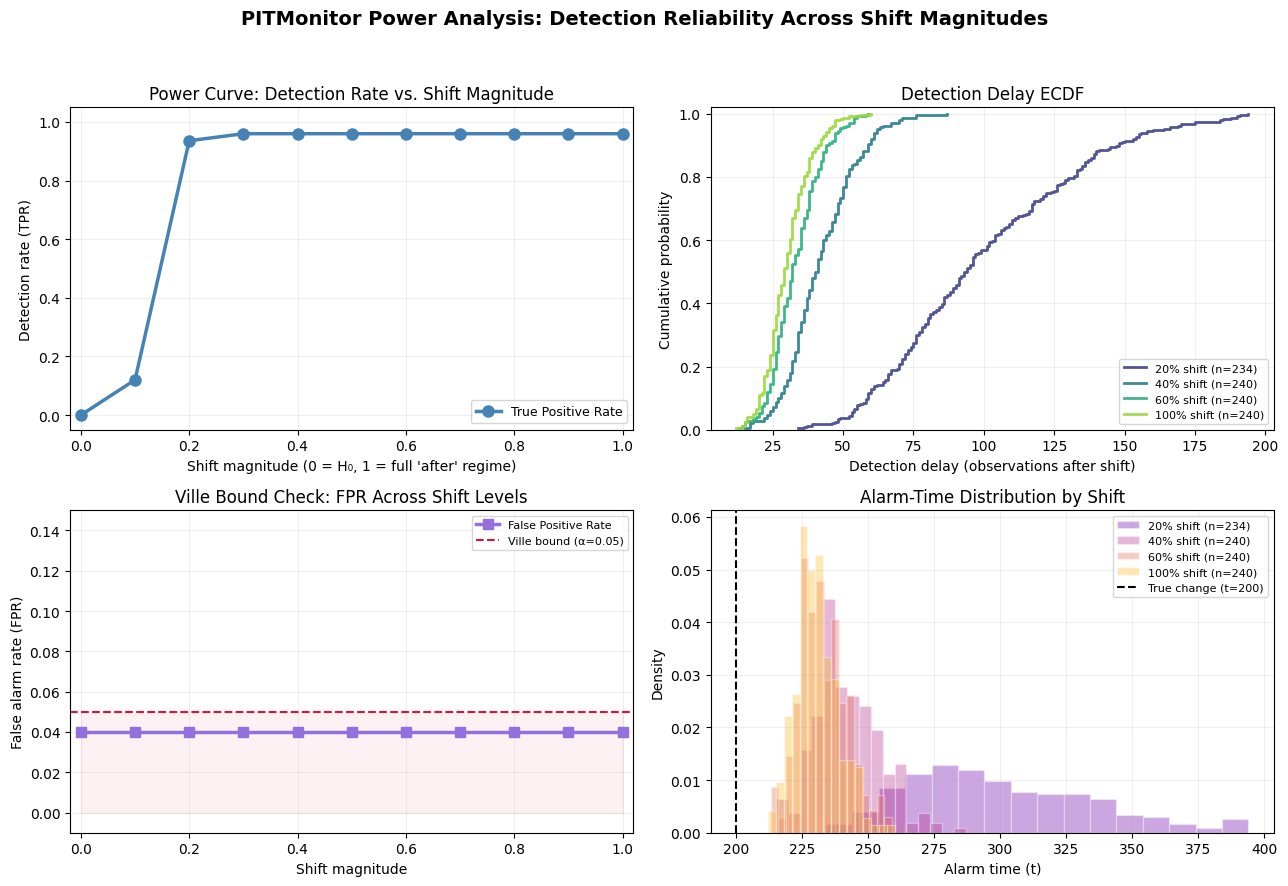

In [ ]:
shifts_list = list(SHIFT_LEVELS)
tprs_list = [power_results[sf]["tpr"] for sf in SHIFT_LEVELS]
fprs_list = [power_results[sf]["false_alarm_rate"] for sf in SHIFT_LEVELS]

fig2, axes2 = plt.subplots(2, 2, figsize=(13, 9))
fig2.suptitle(
    "PITMonitor Power Analysis: Detection Reliability Across Shift Magnitudes",
    fontsize=14,
    fontweight="bold",
    y=0.98,
)

# Panel 1: TPR vs shift magnitude (main power curve)
ax = axes2[0, 0]
ax.plot(
    shifts_list,
    tprs_list,
    "o-",
    color="steelblue",
    lw=2.5,
    markersize=8,
    label="True Positive Rate",
    zorder=3,
)

fpr_h0 = fprs_list[0]

ax.set(
    xlabel="Shift magnitude (0 = H₀, 1 = full 'after' regime)",
    ylabel="Detection rate (TPR)",
    title="Power Curve: Detection Rate vs. Shift Magnitude",
)
ax.set_ylim(-0.05, 1.05)
ax.set_xlim(-0.02, max(shifts_list) + 0.02)
ax.legend(fontsize=9, loc="lower right")
ax.grid(True, alpha=0.2)

# Panel 2: Detection delay distributions
ax = axes2[0, 1]
selected_shifts_viz = [0.20, 0.40, 0.60, 1.0]
colors_delay = plt.cm.viridis(np.linspace(0.2, 0.85, len(selected_shifts_viz)))

for shift_frac, c in zip(selected_shifts_viz, colors_delay):
    if shift_frac in power_results:
        delays = np.asarray(power_results[shift_frac]["delays"], dtype=float)
        if delays.size > 0:
            delays_sorted = np.sort(delays)
            ecdf = np.arange(1, len(delays_sorted) + 1) / len(delays_sorted)
            ax.step(
                delays_sorted,
                ecdf,
                where="post",
                color=c,
                lw=2,
                alpha=0.9,
                label=f"{shift_frac:.0%} shift (n={len(delays)})",
            )

ax.set(
    xlabel="Detection delay (observations after shift)",
    ylabel="Cumulative probability",
    title="Detection Delay ECDF",
)
ax.set_ylim(0.0, 1.02)
ax.legend(fontsize=8)
ax.grid(True, alpha=0.2)

# Panel 3: Ville-bound diagnostic (false alarm control)
ax = axes2[1, 0]
ax.plot(
    shifts_list,
    fprs_list,
    "s-",
    color="mediumpurple",
    lw=2.5,
    markersize=7,
    zorder=3,
    label="False Positive Rate",
)
ax.axhline(
    ALPHA_POWER,
    color="crimson",
    ls="--",
    lw=1.5,
    label=f"Ville bound (α={ALPHA_POWER:.2f})",
)
ax.fill_between(
    shifts_list,
    0,
    [ALPHA_POWER] * len(shifts_list),
    color="crimson",
    alpha=0.06,
)

ax.set(
    xlabel="Shift magnitude",
    ylabel="False alarm rate (FPR)",
    title="Ville Bound Check: FPR Across Shift Levels",
)
ax.set_ylim(-0.01, min(0.20, ALPHA_POWER * 3.0))
ax.set_xlim(-0.02, max(shifts_list) + 0.02)
ax.legend(fontsize=8, loc="upper right")
ax.grid(True, alpha=0.2)

# Panel 4: Alarm-time distribution by shift
ax = axes2[1, 1]
selected_alarm_shifts = [0.20, 0.40, 0.60, 1.0]
colors_alarm = plt.cm.plasma(np.linspace(0.2, 0.85, len(selected_alarm_shifts)))
true_change_time = N_STABLE_POWER + 1

for shift_frac, c in zip(selected_alarm_shifts, colors_alarm):
    if shift_frac in power_results:
        delay_values = np.asarray(power_results[shift_frac]["delays"], dtype=float)
        if delay_values.size > 0:
            alarm_times = N_STABLE_POWER + delay_values
            ax.hist(
                alarm_times,
                bins=16,
                density=True,
                alpha=0.35,
                color=c,
                edgecolor="white",
                label=f"{shift_frac:.0%} shift (n={len(alarm_times)})",
            )

ax.axvline(
    true_change_time,
    color="black",
    ls="--",
    lw=1.5,
    label=f"True change (t={true_change_time})",
)

ax.set(
    xlabel="Alarm time (t)",
    ylabel="Density",
    title="Alarm-Time Distribution by Shift",
)
ax.legend(fontsize=8)
ax.grid(True, alpha=0.2)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()